# GNN for Emerging Market Alpha Prediction

This notebook demonstrates using Graph Neural Networks to predict **next 1-month (21 trading days) beta-adjusted returns (alpha)** of emerging market indices, where the graph structure is derived from the **covariance matrix** of historical returns.

## Key Idea

- **Nodes**: 10 emerging market indices (China, India, Brazil, etc.)
- **Node features**: 30+ features including technical indicators, MSCI World features, and country dummies
- **Graph edges**: Derived from covariance matrix of prior T-day returns
- **Target**: Next 21-day **alpha** (country return - beta × MSCI World return)

## Why Alpha Instead of Total Returns?

Using beta-adjusted returns (alpha) isolates **country-specific performance**:
- Removes common global market movements
- Focuses on what makes each country over/under-perform the world
- More relevant for long-short strategies or country allocation
- Alpha = r_country - β × r_world (where β is rolling beta to MSCI World)

## Why GNN?

Emerging markets are interconnected:
- Global risk-on/risk-off flows affect correlated markets similarly
- If one EM market moves, correlated markets often follow
- GNN can aggregate signals from correlated markets to improve predictions

## Financial Interpretation

The covariance-based graph captures:
- **Contagion effects**: Shocks propagate through correlated markets
- **Common factors**: EM markets share exposure to global factors (USD, commodities)
- **Regional linkages**: Asian markets correlate, Latin American markets correlate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"PyTorch: {torch.__version__}")

PyTorch: 2.2.2


## 1. Data Loading

We select 10 major emerging market indices from 10 different countries:

| Ticker | Index | Country |
|--------|-------|--------|
| I2CHN003 | Shanghai SE Composite | China |
| I2IND007 | S&P CNX Nifty | India |
| I4BRA002 | Bovespa | Brazil |
| I2KOR003 | KOSPI | South Korea |
| I2TWN002 | Taiwan Weighted | Taiwan |
| I4MEX005 | IPC | Mexico |
| I2IDN003 | Jakarta Composite | Indonesia |
| I2THA002 | SET Index | Thailand |
| I3TUR002 | ISE 30 | Turkey |
| I3RUS002 | RTS | Russia |

In [2]:
# Load EM data
df = pd.read_csv('equity_indicies.csv', low_memory=False)

# Load MSCI World data
df_world = pd.read_csv('/Users/oualid/Documents/Teaching/Baruch/DL_for_Finance/repo/DLinFinance_BaruchMFE2025/homeworks/week6/msci_world.csv', low_memory=False)

# Select our 10 EM indices
EM_TICKERS = [
    'I2CHN003',  # China - Shanghai Composite
    'I2IND007',  # India - Nifty
    'I4BRA002',  # Brazil - Bovespa
    'I2KOR003',  # South Korea - KOSPI
    'I2TWN002',  # Taiwan - TAIEX
    'I4MEX005',  # Mexico - IPC
    'I2IDN003',  # Indonesia - Jakarta
    'I2THA002',  # Thailand - SET
    'I3TUR002',  # Turkey - ISE 30
    'I3RUS002',  # Russia - RTS
]

EM_NAMES = [
    'China', 'India', 'Brazil', 'S.Korea', 'Taiwan',
    'Mexico', 'Indonesia', 'Thailand', 'Turkey', 'Russia'
]

# Filter to our indices
df_em = df[df['tic'].isin(EM_TICKERS)].copy()

# Parse dates for EM
df_em['date'] = pd.to_datetime(df_em['datadate'], format='%m/%d/%y', errors='coerce')
df_em.loc[df_em['date'].dt.year > 2050, 'date'] = df_em.loc[df_em['date'].dt.year > 2050, 'date'] - pd.DateOffset(years=100)
df_em = df_em[['tic', 'date', 'prccd']].dropna()
df_em['prccd'] = pd.to_numeric(df_em['prccd'], errors='coerce')
df_em = df_em.dropna()

# Parse dates for MSCI World
df_world['date'] = pd.to_datetime(df_world['datadate'], format='%m/%d/%y', errors='coerce')
df_world.loc[df_world['date'].dt.year > 2050, 'date'] = df_world.loc[df_world['date'].dt.year > 2050, 'date'] - pd.DateOffset(years=100)
df_world = df_world[['date', 'prccd']].dropna()
df_world['prccd'] = pd.to_numeric(df_world['prccd'], errors='coerce')
df_world = df_world.dropna()
df_world = df_world.set_index('date').sort_index()
df_world.columns = ['MSCI_World']

print(f"EM Date range: {df_em['date'].min()} to {df_em['date'].max()}")
print(f"MSCI World Date range: {df_world.index.min()} to {df_world.index.max()}")
print(f"MSCI World records: {len(df_world)}")
print(f"\nRecords per EM index:")
for tic, name in zip(EM_TICKERS, EM_NAMES):
    count = len(df_em[df_em['tic'] == tic])
    print(f"  {name}: {count}")

EM Date range: 2000-01-03 00:00:00 to 2025-12-05 00:00:00
MSCI World Date range: 2000-01-03 00:00:00 to 2025-12-05 00:00:00
MSCI World records: 6765

Records per EM index:
  China: 6765
  India: 6778
  Brazil: 6765
  S.Korea: 6765
  Taiwan: 6770
  Mexico: 6765
  Indonesia: 6765
  Thailand: 6765
  Turkey: 5166
  Russia: 5944


In [3]:
# Pivot EM data to wide format: rows = dates, columns = indices
df_pivot = df_em.pivot(index='date', columns='tic', values='prccd')
df_pivot = df_pivot[EM_TICKERS]  # Ensure consistent order
df_pivot.columns = EM_NAMES

# Align EM and MSCI World on common dates
common_dates_all = df_pivot.index.intersection(df_world.index)
df_pivot = df_pivot.loc[common_dates_all]
df_world = df_world.loc[common_dates_all]

# Drop rows with any missing values
valid_rows = df_pivot.dropna().index.intersection(df_world.dropna().index)
df_pivot = df_pivot.loc[valid_rows]
df_world = df_world.loc[valid_rows]
df_pivot = df_pivot.sort_index()
df_world = df_world.sort_index()

print(f"Price data shape (EM): {df_pivot.shape}")
print(f"Price data shape (MSCI World): {df_world.shape}")
print(f"Date range (after alignment): {df_pivot.index.min()} to {df_pivot.index.max()}")
print(f"\nFirst few rows (EM):")
df_pivot.head()

Price data shape (EM): (4338, 10)
Price data shape (MSCI World): (4338, 1)
Date range (after alignment): 2006-02-17 00:00:00 to 2022-10-05 00:00:00

First few rows (EM):


,China,India,Brazil,S.Korea,Taiwan,Mexico,Indonesia,Thailand,Turkey,Russia
date,,,,,,,,,,
2006-02-17,1267.408,2981.50,38421.83,1332.73,6673.75,18480.78,1243.475,739.35,59333.17,1428.14
2006-02-20,1267.542,3005.85,38539.18,1348.25,6686.55,18542.58,1247.414,734.65,59917.84,1459.48
2006-02-21,1288.419,3035.50,38165.97,1346.49,6631.51,18497.38,1236.089,727.76,59812.93,1444.35
2006-02-22,1284.226,3050.80,38246.40,1340.58,6530.70,18780.46,1231.250,728.60,59080.20,1465.62
2006-02-23,1288.847,3062.10,38405.48,1361.23,6474.69,19117.72,1224.164,732.68,59292.68,1465.62


In [4]:
# Compute daily returns for EM and MSCI World
returns = df_pivot.pct_change().dropna()
world_returns = df_world.pct_change().dropna()

# Align
common_ret_dates = returns.index.intersection(world_returns.index)
returns = returns.loc[common_ret_dates]
world_returns = world_returns.loc[common_ret_dates]

print(f"EM Returns shape: {returns.shape}")
print(f"World Returns shape: {world_returns.shape}")
print(f"\nEM Return statistics:")
print(returns.describe().T[['mean', 'std', 'min', 'max']])
print(f"\nMSCI World Return statistics:")
print(world_returns.describe().T[['mean', 'std', 'min', 'max']])

EM Returns shape: (4337, 10)
World Returns shape: (4337, 1)

EM Return statistics:
               mean       std       min       max
China      0.000315  0.015088 -0.088407  0.094551
India      0.000494  0.013736 -0.129805  0.177441
Brazil     0.000403  0.017023 -0.147804  0.146578
S.Korea    0.000190  0.012089 -0.105705  0.119457
Taiwan     0.000231  0.011218 -0.065133  0.067422
Mexico     0.000279  0.011807 -0.070084  0.110052
Indonesia  0.000478  0.012393 -0.103754  0.101907
Thailand   0.000244  0.011706 -0.148395  0.111567
Turkey     0.000348  0.022786 -0.989989  0.135706
Russia     0.000196  0.021942 -0.383021  0.261176

MSCI World Return statistics:
                mean       std       min       max
MSCI_World  0.000208  0.010678 -0.099146  0.095229


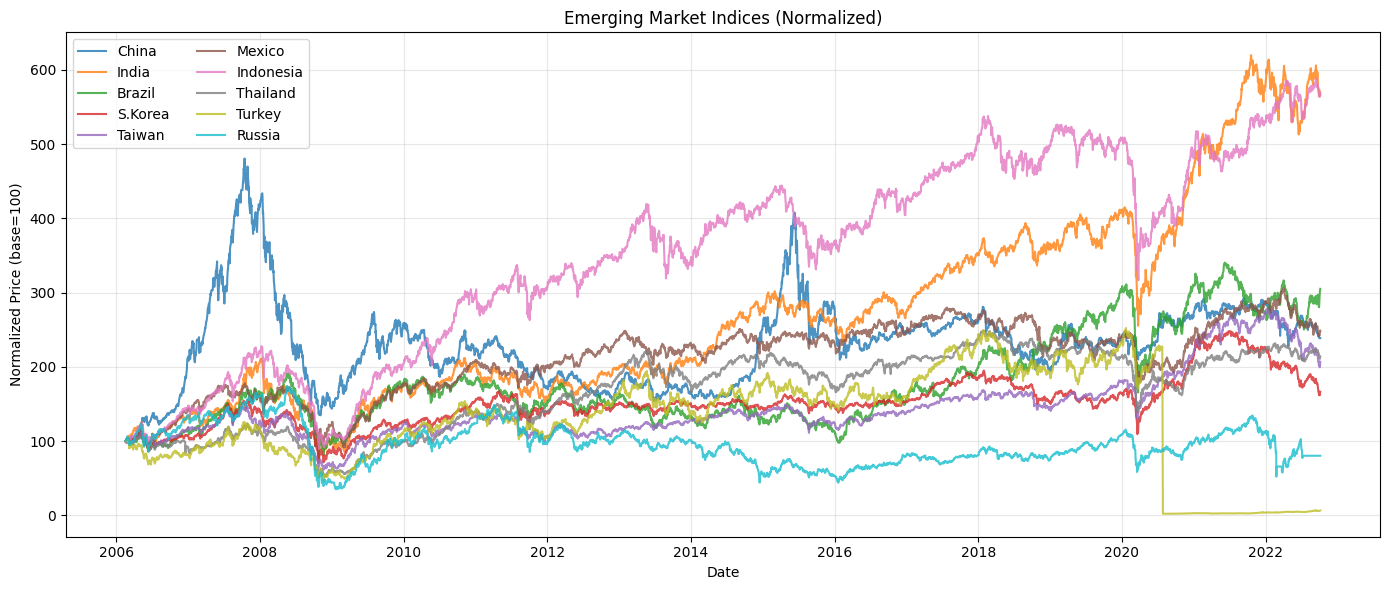

In [5]:
# Plot normalized price series
fig, ax = plt.subplots(figsize=(14, 6))

normalized = df_pivot / df_pivot.iloc[0] * 100
for col in normalized.columns:
    ax.plot(normalized.index, normalized[col], label=col, alpha=0.8)

ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price (base=100)')
ax.set_title('Emerging Market Indices (Normalized)')
ax.legend(loc='upper left', ncol=2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Feature Engineering

We compute 35+ features for each index organized into 6 categories:

### Technical Indicators (10)
1. **Momentum (21-day)**: Return over past month
2. **Momentum (63-day)**: Return over past quarter
3. **Volatility (21-day)**: Std of returns over past month
4. **RSI (14-day)**: Relative Strength Index
5. **MA Ratio (50-day)**: Price / 50-day moving average
6. **MACD**: 12-day EMA - 26-day EMA
7. **Bollinger Position**: (Price - MA20) / (2 * std20)
8. **ATR (14-day)**: Average True Range (using close-to-close)
9. **Volatility Ratio**: Rolling std ratio (recent vs longer-term)
10. **Drawdown (63-day)**: Distance from 63-day high

### Mean-Reversion Features (3)
11. **Distance from 252-day high**: How far below annual high
12. **Distance from 252-day low**: How far above annual low
13. **Return Z-score**: How unusual is recent return vs rolling history

### Cross-Asset/Macro Proxies (3)
14. **Correlation with EM average**: Rolling correlation with average EM return
15. **Cross-sectional dispersion**: Dispersion across all EM indices (risk-on/off proxy)
16. **Beta to EM average**: Rolling beta to the EM average return

### MSCI World Features (5) - NEW!
17. **World Momentum (21-day)**: MSCI World return over past month
18. **World Momentum (63-day)**: MSCI World return over past quarter
19. **World Volatility (21-day)**: MSCI World volatility
20. **Beta to World**: Rolling beta of country vs MSCI World
21. **Correlation with World**: Rolling correlation with MSCI World

### Calendar Features (4)
22-23. **Month of year**: Cyclical encoding (sin/cos) for seasonality
24-25. **Day of week**: Cyclical encoding (sin/cos) for intra-week effects

### Country One-Hot Encoding (10)
26-35. **Country indicators**: One-hot encoding for each of the 10 countries

In [6]:
def compute_rsi(prices: pd.Series, window: int = 14) -> pd.Series:
    """Compute Relative Strength Index."""
    delta = prices.diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-10)
    return 100 - (100 / (1 + rs))


def compute_features(prices: pd.DataFrame, returns: pd.DataFrame = None, 
                     world_prices: pd.DataFrame = None, world_returns: pd.DataFrame = None) -> pd.DataFrame:
    """
    Compute technical features for each index.

    Features include:
    - Original 10 technical indicators
    - Mean-reversion features (distance from 252-day high/low, return z-score)
    - Cross-asset/macro proxies (correlation with EM avg, dispersion, beta)
    - MSCI World features (world momentum, volatility, beta to world, correlation with world)
    - Calendar features (month cyclical, day of week cyclical)
    - Country one-hot encoding

    Returns DataFrame with MultiIndex columns: (index_name, feature_name)
    """
    if returns is None:
        returns = prices.pct_change()

    # Compute EM average return for cross-asset features
    em_avg_return = returns.mean(axis=1)

    # Compute cross-sectional dispersion (std across indices each day)
    cross_dispersion = returns.std(axis=1)
    
    # Compute world returns if world prices provided
    if world_returns is None and world_prices is not None:
        world_returns = world_prices.pct_change()
    
    # Get world return series (flatten if DataFrame)
    if world_returns is not None:
        if isinstance(world_returns, pd.DataFrame):
            world_ret = world_returns.iloc[:, 0]
        else:
            world_ret = world_returns
    else:
        world_ret = None

    features_list = []
    n_indices = len(prices.columns)

    for idx, col in enumerate(prices.columns):
        p = prices[col]
        r = returns[col]

        feat = pd.DataFrame(index=prices.index)

        # ========== ORIGINAL TECHNICAL FEATURES (10) ==========
        # 1. Momentum (21-day)
        feat['mom_21'] = p.pct_change(21)

        # 2. Momentum (63-day)
        feat['mom_63'] = p.pct_change(63)

        # 3. Volatility (21-day)
        feat['vol_21'] = r.rolling(21).std()

        # 4. RSI (14-day)
        feat['rsi_14'] = compute_rsi(p, 14)

        # 5. MA Ratio (50-day)
        feat['ma_ratio_50'] = p / p.rolling(50).mean()

        # 6. MACD
        ema_12 = p.ewm(span=12, adjust=False).mean()
        ema_26 = p.ewm(span=26, adjust=False).mean()
        feat['macd'] = (ema_12 - ema_26) / p  # Normalize by price

        # 7. Bollinger Position
        ma_20 = p.rolling(20).mean()
        std_20 = p.rolling(20).std()
        feat['bollinger'] = (p - ma_20) / (2 * std_20 + 1e-10)

        # 8. ATR proxy (using close-to-close volatility)
        feat['atr_14'] = r.abs().rolling(14).mean()

        # 9. Volatility ratio (short-term vs long-term)
        feat['vol_ratio'] = r.rolling(5).std() / (r.rolling(21).std() + 1e-10)

        # 10. Drawdown (63-day)
        rolling_max_63 = p.rolling(63).max()
        feat['drawdown_63'] = (p - rolling_max_63) / (rolling_max_63 + 1e-10)

        # ========== MEAN-REVERSION FEATURES (3) ==========
        # 11. Distance from 252-day high (normalized)
        rolling_max_252 = p.rolling(252).max()
        feat['dist_from_high_252'] = (p - rolling_max_252) / (rolling_max_252 + 1e-10)

        # 12. Distance from 252-day low (normalized)
        rolling_min_252 = p.rolling(252).min()
        feat['dist_from_low_252'] = (p - rolling_min_252) / (rolling_min_252 + 1e-10)

        # 13. Return z-score (63-day rolling)
        ret_mean = r.rolling(63).mean()
        ret_std = r.rolling(63).std()
        feat['return_zscore'] = (r - ret_mean) / (ret_std + 1e-10)

        # ========== CROSS-ASSET/MACRO PROXY FEATURES (3) ==========
        # 14. Rolling correlation with EM average (63-day)
        feat['corr_with_em_avg'] = r.rolling(63).corr(em_avg_return)

        # 15. Cross-sectional dispersion (same for all indices on each day)
        feat['cross_dispersion'] = cross_dispersion.rolling(21).mean()

        # 16. Rolling beta to EM average (63-day)
        cov_with_avg = r.rolling(63).cov(em_avg_return)
        var_avg = em_avg_return.rolling(63).var()
        feat['beta_to_em_avg'] = cov_with_avg / (var_avg + 1e-10)

        # ========== MSCI WORLD FEATURES (5) ==========
        if world_ret is not None and world_prices is not None:
            # Get world prices (flatten if DataFrame)
            if isinstance(world_prices, pd.DataFrame):
                world_p = world_prices.iloc[:, 0]
            else:
                world_p = world_prices
            
            # 17. World Momentum (21-day)
            feat['world_mom_21'] = world_p.pct_change(21)
            
            # 18. World Momentum (63-day)
            feat['world_mom_63'] = world_p.pct_change(63)
            
            # 19. World Volatility (21-day)
            feat['world_vol_21'] = world_ret.rolling(21).std()
            
            # 20. Rolling beta to MSCI World (63-day)
            cov_with_world = r.rolling(63).cov(world_ret)
            var_world = world_ret.rolling(63).var()
            feat['beta_to_world'] = cov_with_world / (var_world + 1e-10)
            
            # 21. Rolling correlation with MSCI World (63-day)
            feat['corr_with_world'] = r.rolling(63).corr(world_ret)

        # ========== CALENDAR FEATURES (4) ==========
        # 22-23. Month of year (cyclical encoding using sin/cos)
        month = prices.index.month
        feat['month_sin'] = np.sin(2 * np.pi * month / 12)
        feat['month_cos'] = np.cos(2 * np.pi * month / 12)

        # 24-25. Day of week (cyclical encoding using sin/cos)
        dayofweek = prices.index.dayofweek
        feat['dow_sin'] = np.sin(2 * np.pi * dayofweek / 5)  # 5 trading days
        feat['dow_cos'] = np.cos(2 * np.pi * dayofweek / 5)

        # ========== COUNTRY ONE-HOT ENCODING (10) ==========
        # Create one-hot encoding for each country
        for j, country in enumerate(prices.columns):
            feat[f'country_{country}'] = 1.0 if j == idx else 0.0

        # Add column prefix
        feat.columns = pd.MultiIndex.from_product([[col], feat.columns])
        features_list.append(feat)

    return pd.concat(features_list, axis=1)


# Compute features (pass returns and world data for cross-asset features)
features = compute_features(df_pivot, returns, df_world, world_returns)

# Drop rows with NaN (due to rolling windows - 252-day features need more history)
features = features.dropna()

print(f"Features shape: {features.shape}")
print(f"Date range: {features.index.min()} to {features.index.max()}")

# Get feature names
feature_names = features.columns.get_level_values(1).unique().tolist()
print(f"\nNumber of features per index: {len(feature_names)}")
print(f"\nFeature categories:")
print(f"  Technical (10): mom_21, mom_63, vol_21, rsi_14, ma_ratio_50, macd, bollinger, atr_14, vol_ratio, drawdown_63")
print(f"  Mean-reversion (3): dist_from_high_252, dist_from_low_252, return_zscore")
print(f"  Cross-asset (3): corr_with_em_avg, cross_dispersion, beta_to_em_avg")
print(f"  MSCI World (5): world_mom_21, world_mom_63, world_vol_21, beta_to_world, corr_with_world")
print(f"  Calendar (4): month_sin, month_cos, dow_sin, dow_cos")
print(f"  Country (10): country_* one-hot encoding")

Features shape: (4086, 350)
Date range: 2007-02-05 00:00:00 to 2022-10-04 00:00:00

Number of features per index: 35

Feature categories:
  Technical (10): mom_21, mom_63, vol_21, rsi_14, ma_ratio_50, macd, bollinger, atr_14, vol_ratio, drawdown_63
  Mean-reversion (3): dist_from_high_252, dist_from_low_252, return_zscore
  Cross-asset (3): corr_with_em_avg, cross_dispersion, beta_to_em_avg
  MSCI World (5): world_mom_21, world_mom_63, world_vol_21, beta_to_world, corr_with_world
  Calendar (4): month_sin, month_cos, dow_sin, dow_cos
  Country (10): country_* one-hot encoding


Rolling Beta Statistics (63-day window):
               mean       std       min       max
China      0.286305  0.311610 -0.475363  1.781450
India      0.498214  0.261028 -0.008118  1.925282
Brazil     1.003195  0.358706  0.024270  2.118289
S.Korea    0.409183  0.194725 -0.264615  1.086537
Taiwan     0.343601  0.173182 -0.223707  1.083615
Mexico     0.735107  0.278143  0.193691  1.881266
Indonesia  0.329343  0.263513 -0.354870  1.401167
Thailand   0.367246  0.236600 -0.162378  1.683149
Turkey     0.751921  0.450768 -1.574463  2.013621
Russia     1.044954  0.497097 -0.353426  3.208187

Target: 21-day forward ALPHA (beta-adjusted return)
Beta estimation window: 63 days
Filtered to period: 2010-01-01 to 2019-12-31
Aligned data shape: 2608 days, 10 indices
Date range: 2010-01-01 00:00:00 to 2019-12-31 00:00:00

Alpha (beta-adjusted return) statistics:
               mean       std       min       max
China      0.000556  0.060566 -0.304653  0.268207
India      0.005082  0.036519 -0.141318 

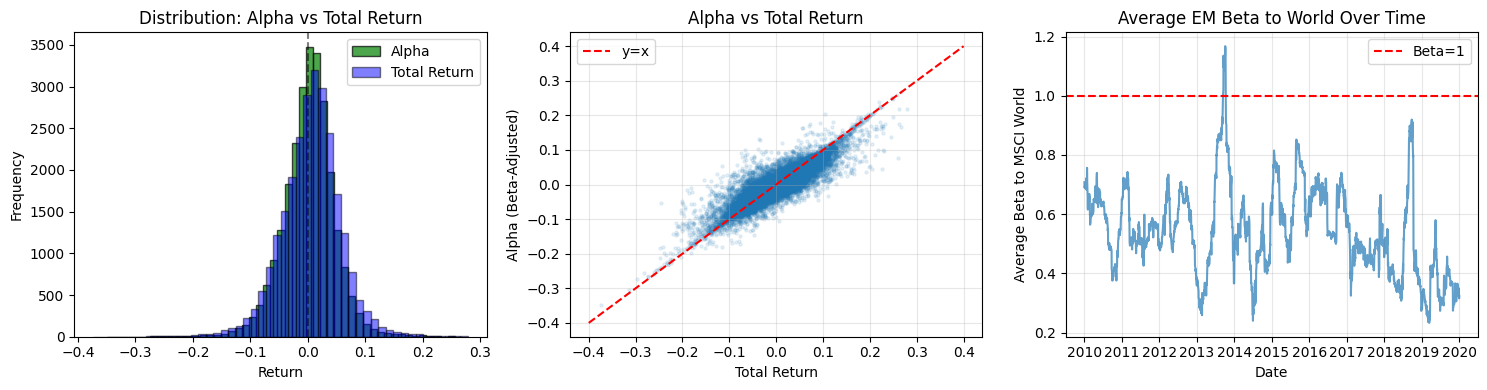


Correlation between alpha and total return: 0.8877


In [7]:
# Compute 21-day (1 month) forward ALPHA as target
# Alpha = country_return - beta * world_return
# Beta is computed using rolling 63-day covariance/variance

FORWARD_DAYS = 21  # 1 month of trading days
BETA_WINDOW = 63   # Rolling window for beta estimation

# Compute forward returns for EM countries: (P_{t+21} - P_t) / P_t
forward_returns = df_pivot.pct_change(periods=FORWARD_DAYS).shift(-FORWARD_DAYS)

# Compute forward returns for MSCI World
world_forward_returns = df_world.pct_change(periods=FORWARD_DAYS).shift(-FORWARD_DAYS)

# Get world return series
if isinstance(world_returns, pd.DataFrame):
    world_ret = world_returns.iloc[:, 0]
else:
    world_ret = world_returns

if isinstance(world_forward_returns, pd.DataFrame):
    world_fwd_ret = world_forward_returns.iloc[:, 0]
else:
    world_fwd_ret = world_forward_returns

# Compute rolling beta for each country vs MSCI World
# Beta = Cov(r_country, r_world) / Var(r_world)
rolling_betas = pd.DataFrame(index=returns.index, columns=EM_NAMES)

for col in EM_NAMES:
    country_ret = returns[col]
    cov_with_world = country_ret.rolling(BETA_WINDOW).cov(world_ret)
    var_world = world_ret.rolling(BETA_WINDOW).var()
    rolling_betas[col] = cov_with_world / (var_world + 1e-10)

print(f"Rolling Beta Statistics (63-day window):")
print(rolling_betas.dropna().describe().T[['mean', 'std', 'min', 'max']])

# Compute forward alpha: alpha = r_country - beta * r_world
# Use the rolling beta computed up to time t to adjust forward returns
forward_alpha = pd.DataFrame(index=forward_returns.index, columns=EM_NAMES)

for col in EM_NAMES:
    # Forward alpha = forward country return - beta * forward world return
    forward_alpha[col] = forward_returns[col] - rolling_betas[col] * world_fwd_ret

# Align indices - only keep dates where we have both features and valid forward alpha
common_dates = features.index.intersection(forward_alpha.dropna().index)

# Filter to 2010-2019 period
START_DATE = '2010-01-01'
END_DATE = '2019-12-31'
common_dates = common_dates[(common_dates >= START_DATE) & (common_dates <= END_DATE)]

features_aligned = features.loc[common_dates]
target_alpha = forward_alpha.loc[common_dates]

# Also keep total returns for comparison
target_returns = forward_returns.loc[common_dates]

print(f"\nTarget: {FORWARD_DAYS}-day forward ALPHA (beta-adjusted return)")
print(f"Beta estimation window: {BETA_WINDOW} days")
print(f"Filtered to period: {START_DATE} to {END_DATE}")
print(f"Aligned data shape: {features_aligned.shape[0]} days, {len(EM_NAMES)} indices")
print(f"Date range: {common_dates.min()} to {common_dates.max()}")

# Show target statistics
print(f"\nAlpha (beta-adjusted return) statistics:")
print(target_alpha.describe().T[['mean', 'std', 'min', 'max']])

print(f"\nTotal return statistics (for comparison):")
print(target_returns.describe().T[['mean', 'std', 'min', 'max']])

# Visualize the difference between total return and alpha
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Alpha distribution
ax = axes[0]
alpha_flat = target_alpha.values.flatten()
alpha_flat = alpha_flat[~np.isnan(alpha_flat)]
ax.hist(alpha_flat, bins=50, alpha=0.7, color='green', edgecolor='black', label='Alpha')
ret_flat = target_returns.values.flatten()
ret_flat = ret_flat[~np.isnan(ret_flat)]
ax.hist(ret_flat, bins=50, alpha=0.5, color='blue', edgecolor='black', label='Total Return')
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Return')
ax.set_ylabel('Frequency')
ax.set_title('Distribution: Alpha vs Total Return')
ax.legend()

# 2. Alpha vs Total Return scatter
ax = axes[1]
ax.scatter(ret_flat, alpha_flat, alpha=0.1, s=5)
ax.plot([-0.4, 0.4], [-0.4, 0.4], 'r--', label='y=x')
ax.set_xlabel('Total Return')
ax.set_ylabel('Alpha (Beta-Adjusted)')
ax.set_title('Alpha vs Total Return')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Rolling beta over time (average across countries)
ax = axes[2]
beta_mean = rolling_betas.loc[common_dates].mean(axis=1)
ax.plot(beta_mean.index, beta_mean.values, alpha=0.7)
ax.axhline(y=1, color='red', linestyle='--', label='Beta=1')
ax.set_xlabel('Date')
ax.set_ylabel('Average Beta to MSCI World')
ax.set_title('Average EM Beta to World Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCorrelation between alpha and total return: {np.corrcoef(alpha_flat, ret_flat)[0,1]:.4f}")

In [8]:
# Feature vs Target Analysis: Binned scatter plots
# Shows the relationship between each feature and the 21-day forward ALPHA

# Flatten data for analysis
feature_names_list = features_aligned.columns.get_level_values(1).unique().tolist()

# Separate continuous and categorical features
continuous_features = [f for f in feature_names_list if not f.startswith('country_')]
categorical_features = [f for f in feature_names_list if f.startswith('country_')]

# Calendar features are technically continuous but have limited unique values
calendar_features = ['month_sin', 'month_cos', 'dow_sin', 'dow_cos']

# Prepare data: flatten across all indices
X_flat = []
y_flat = []
for idx_name in EM_NAMES:
    X_flat.append(features_aligned[idx_name].values)
    y_flat.append(target_alpha[idx_name].values)  # Using alpha instead of total returns

X_flat = np.vstack(X_flat)  # (n_samples * 10, n_features)
y_flat = np.concatenate(y_flat)  # (n_samples * 10,)

# Create a DataFrame for easier analysis
df_analysis = pd.DataFrame(X_flat, columns=feature_names_list)
df_analysis['target'] = y_flat

print(f"Analysis data shape: {df_analysis.shape}")
print(f"Target: 21-day forward ALPHA (beta-adjusted return)")
print(f"\nContinuous features ({len(continuous_features)}): {[f for f in continuous_features if f not in calendar_features]}")
print(f"Calendar features ({len(calendar_features)}): {calendar_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

Analysis data shape: (26080, 36)
Target: 21-day forward ALPHA (beta-adjusted return)

Continuous features (25): ['mom_21', 'mom_63', 'vol_21', 'rsi_14', 'ma_ratio_50', 'macd', 'bollinger', 'atr_14', 'vol_ratio', 'drawdown_63', 'dist_from_high_252', 'dist_from_low_252', 'return_zscore', 'corr_with_em_avg', 'cross_dispersion', 'beta_to_em_avg', 'world_mom_21', 'world_mom_63', 'world_vol_21', 'beta_to_world', 'corr_with_world']
Calendar features (4): ['month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Categorical features (10): ['country_China', 'country_India', 'country_Brazil', 'country_S.Korea', 'country_Taiwan', 'country_Mexico', 'country_Indonesia', 'country_Thailand', 'country_Turkey', 'country_Russia']


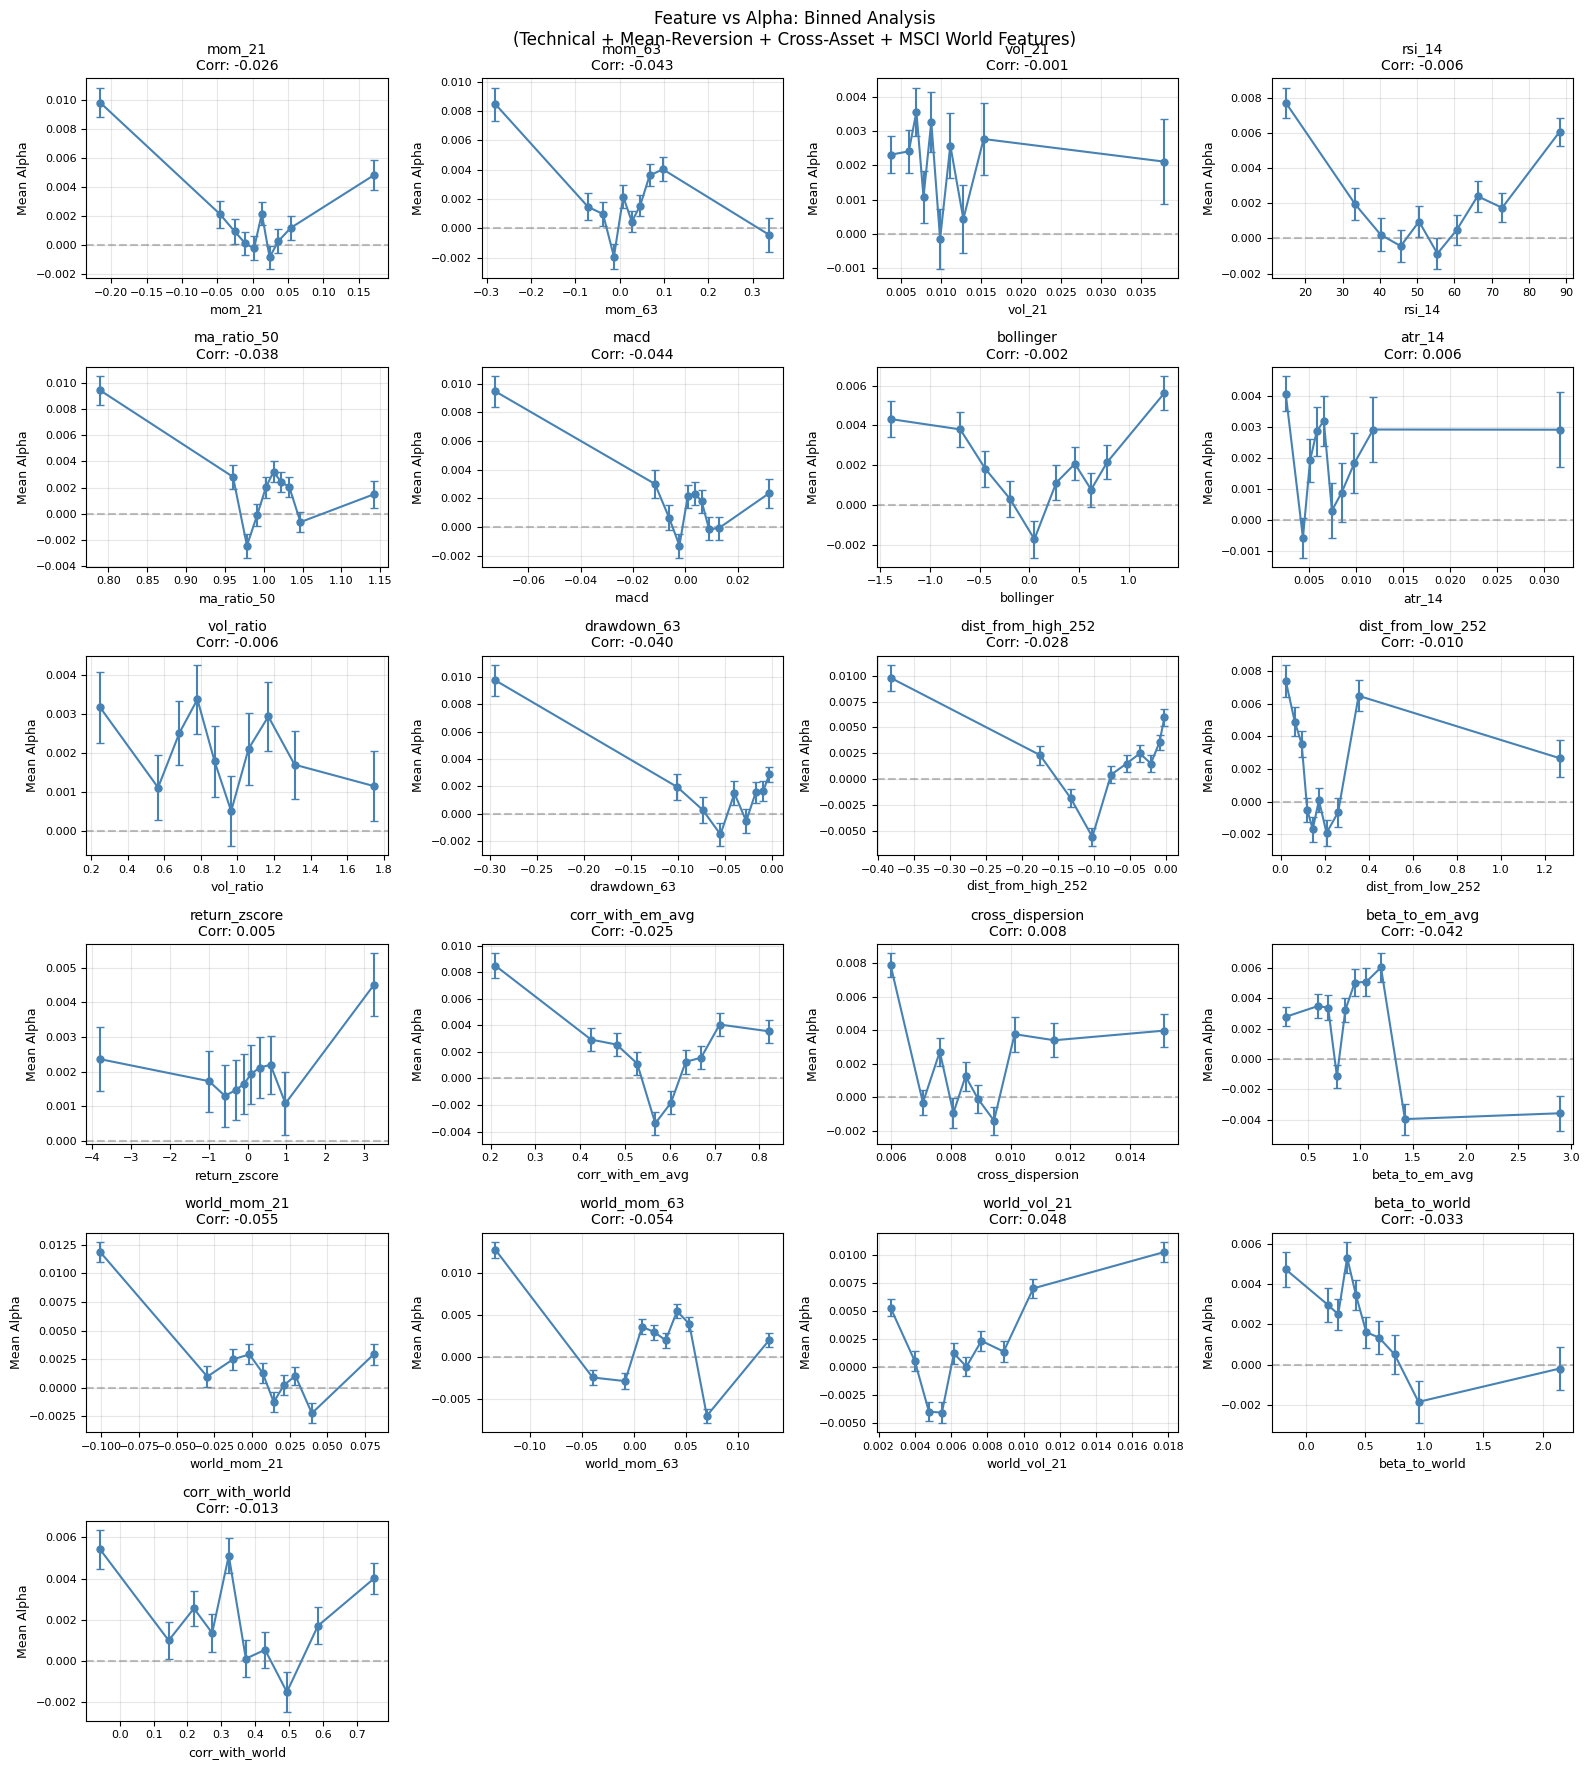

In [9]:
# Plot binned scatter plots for continuous features (excluding country dummies)
# Technical + Mean-reversion + Cross-asset + MSCI World features

tech_and_macro_features = [f for f in continuous_features if f not in calendar_features]
n_features_to_plot = len(tech_and_macro_features)
n_cols = 4
n_rows = (n_features_to_plot + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows))
axes = axes.flatten()

n_bins = 10

for idx, feat_name in enumerate(tech_and_macro_features):
    ax = axes[idx]
    
    x = df_analysis[feat_name].values
    y = df_analysis['target'].values
    
    # Remove NaN
    valid = ~(np.isnan(x) | np.isnan(y))
    x, y = x[valid], y[valid]
    
    # Create bins based on feature values
    bin_edges = np.percentile(x, np.linspace(0, 100, n_bins + 1))
    bin_edges = np.unique(bin_edges)
    
    bin_centers = []
    bin_means = []
    bin_stds = []
    
    for i in range(len(bin_edges) - 1):
        mask = (x >= bin_edges[i]) & (x < bin_edges[i+1])
        if i == len(bin_edges) - 2:
            mask = (x >= bin_edges[i]) & (x <= bin_edges[i+1])
        
        if mask.sum() > 10:  # Require at least 10 samples
            bin_centers.append((bin_edges[i] + bin_edges[i+1]) / 2)
            bin_means.append(y[mask].mean())
            bin_stds.append(y[mask].std() / np.sqrt(mask.sum()))
    
    bin_centers = np.array(bin_centers)
    bin_means = np.array(bin_means)
    bin_stds = np.array(bin_stds)
    
    # Plot
    ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o-', 
                color='steelblue', capsize=3, markersize=5, linewidth=1.5)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Compute correlation
    corr = np.corrcoef(x, y)[0, 1]
    
    ax.set_xlabel(feat_name, fontsize=9)
    ax.set_ylabel('Mean Alpha', fontsize=9)
    ax.set_title(f'{feat_name}\nCorr: {corr:.3f}', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', labelsize=8)

# Hide unused axes
for idx in range(n_features_to_plot, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Feature vs Alpha: Binned Analysis\n(Technical + Mean-Reversion + Cross-Asset + MSCI World Features)', fontsize=12)
plt.tight_layout()
plt.show()

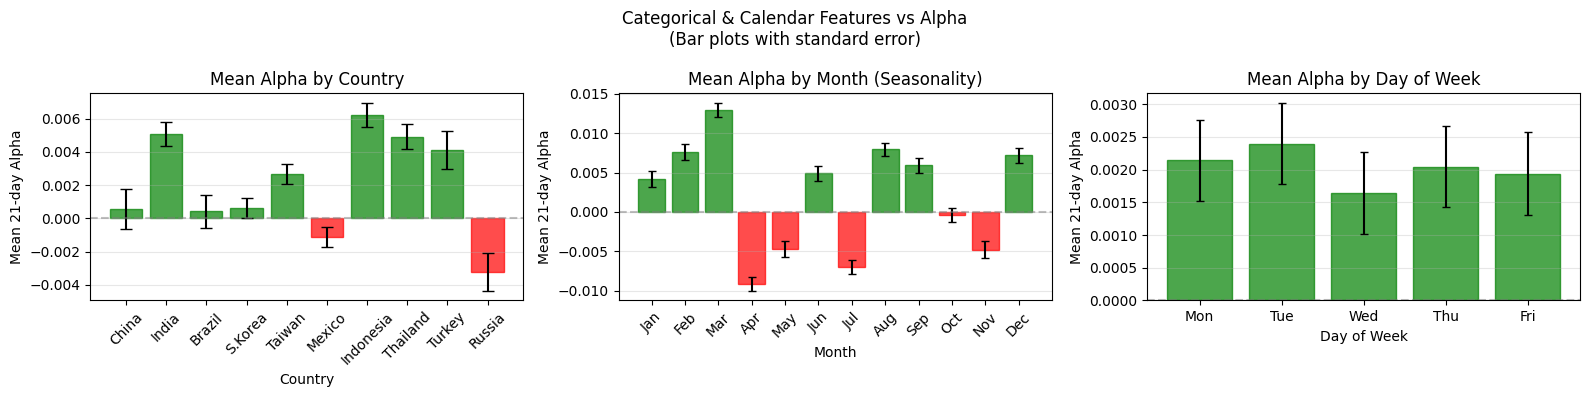


Feature Importance Summary (correlation with alpha):
--------------------------------------------------
  world_mom_21              -0.0548
  world_mom_63              -0.0537
  world_vol_21              +0.0476
  macd                      -0.0443
  mom_63                    -0.0432
  month_cos                 +0.0427
  beta_to_em_avg            -0.0423
  drawdown_63               -0.0403
  ma_ratio_50               -0.0380
  beta_to_world             -0.0325


In [10]:
# Bar plots for categorical features (Country) and Calendar features

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1. Country bar plot - mean alpha by country
ax = axes[0]
country_alpha = {}
for feat in categorical_features:
    country_name = feat.replace('country_', '')
    mask = df_analysis[feat] == 1.0
    if mask.sum() > 0:
        country_alpha[country_name] = {
            'mean': df_analysis.loc[mask, 'target'].mean(),
            'se': df_analysis.loc[mask, 'target'].std() / np.sqrt(mask.sum())
        }

countries = list(country_alpha.keys())
means = [country_alpha[c]['mean'] for c in countries]
errors = [country_alpha[c]['se'] for c in countries]

bars = ax.bar(countries, means, yerr=errors, capsize=4, color='steelblue', alpha=0.7, edgecolor='black')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Country')
ax.set_ylabel('Mean 21-day Alpha')
ax.set_title('Mean Alpha by Country')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

# Color bars by positive/negative
for bar, mean in zip(bars, means):
    bar.set_color('green' if mean > 0 else 'red')
    bar.set_alpha(0.7)

# 2. Month bar plot - convert sin/cos back to month
ax = axes[1]

# Compute month from sin/cos encoding
month_sin = df_analysis['month_sin'].values
month_cos = df_analysis['month_cos'].values
# atan2 gives angle, convert back to month (1-12)
angles = np.arctan2(month_sin, month_cos)
months = np.round((angles / (2 * np.pi)) * 12).astype(int)
months = np.where(months <= 0, months + 12, months)

month_alpha = {}
for m in range(1, 13):
    mask = months == m
    if mask.sum() > 0:
        month_alpha[m] = {
            'mean': df_analysis.loc[mask, 'target'].mean(),
            'se': df_analysis.loc[mask, 'target'].std() / np.sqrt(mask.sum())
        }

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
means = [month_alpha.get(m, {'mean': 0})['mean'] for m in range(1, 13)]
errors = [month_alpha.get(m, {'se': 0})['se'] for m in range(1, 13)]

bars = ax.bar(month_names, means, yerr=errors, capsize=3, color='steelblue', alpha=0.7, edgecolor='black')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Month')
ax.set_ylabel('Mean 21-day Alpha')
ax.set_title('Mean Alpha by Month (Seasonality)')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

for bar, mean in zip(bars, means):
    bar.set_color('green' if mean > 0 else 'red')
    bar.set_alpha(0.7)

# 3. Day of week bar plot
ax = axes[2]

# Compute day of week from sin/cos encoding
dow_sin = df_analysis['dow_sin'].values
dow_cos = df_analysis['dow_cos'].values
angles = np.arctan2(dow_sin, dow_cos)
days = np.round((angles / (2 * np.pi)) * 5).astype(int)
days = np.where(days < 0, days + 5, days)

dow_alpha = {}
for d in range(5):
    mask = days == d
    if mask.sum() > 0:
        dow_alpha[d] = {
            'mean': df_analysis.loc[mask, 'target'].mean(),
            'se': df_analysis.loc[mask, 'target'].std() / np.sqrt(mask.sum())
        }

day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
means = [dow_alpha.get(d, {'mean': 0})['mean'] for d in range(5)]
errors = [dow_alpha.get(d, {'se': 0})['se'] for d in range(5)]

bars = ax.bar(day_names, means, yerr=errors, capsize=3, color='steelblue', alpha=0.7, edgecolor='black')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Mean 21-day Alpha')
ax.set_title('Mean Alpha by Day of Week')
ax.grid(True, alpha=0.3, axis='y')

for bar, mean in zip(bars, means):
    bar.set_color('green' if mean > 0 else 'red')
    bar.set_alpha(0.7)

plt.suptitle('Categorical & Calendar Features vs Alpha\n(Bar plots with standard error)', fontsize=12)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nFeature Importance Summary (correlation with alpha):")
print("-" * 50)
correlations = []
for feat in feature_names_list:
    if not feat.startswith('country_'):
        x = df_analysis[feat].values
        y = df_analysis['target'].values
        valid = ~(np.isnan(x) | np.isnan(y))
        if valid.sum() > 100:
            corr = np.corrcoef(x[valid], y[valid])[0, 1]
            correlations.append((feat, corr))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)
for feat, corr in correlations[:10]:
    print(f"  {feat:<25} {corr:+.4f}")

## 3. Graph Construction from Covariance

We construct the graph adjacency matrix from the **covariance matrix** of returns over the prior T days.

For each prediction date $t$:
$$\Sigma_t = \text{Cov}(r_{t-T:t})$$

We convert covariance to adjacency by:
1. Computing correlation matrix (normalized covariance)
2. Taking absolute value (both positive and negative correlations indicate linkage)
3. Setting diagonal to 0 (no self-loops)

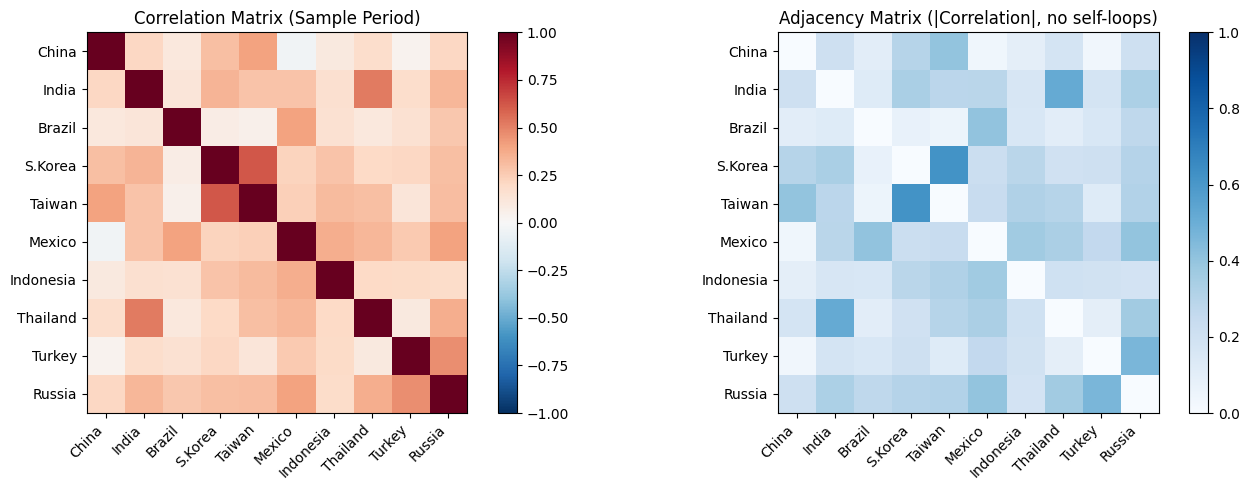


Average absolute correlation: 0.219
Max absolute correlation: 0.620


In [11]:
def compute_correlation_matrix(returns_window: pd.DataFrame) -> np.ndarray:
    """
    Compute correlation matrix from returns.
    Returns adjacency matrix with absolute correlations, zero diagonal.
    """
    corr = returns_window.corr().values
    # Use absolute correlation as edge weight
    adj = np.abs(corr)
    # Remove self-loops
    np.fill_diagonal(adj, 0)
    return adj


# Compute a sample correlation matrix for visualization
COV_WINDOW = 63  # 3 months of daily returns

# Use last 63 days of training period for visualization
sample_returns = returns.loc[features.index[-252-COV_WINDOW:-252]]
sample_adj = compute_correlation_matrix(sample_returns)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation matrix
ax = axes[0]
im = ax.imshow(sample_returns.corr().values, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xticks(range(len(EM_NAMES)))
ax.set_yticks(range(len(EM_NAMES)))
ax.set_xticklabels(EM_NAMES, rotation=45, ha='right')
ax.set_yticklabels(EM_NAMES)
ax.set_title('Correlation Matrix (Sample Period)')
plt.colorbar(im, ax=ax)

# Adjacency matrix (absolute correlation)
ax = axes[1]
im = ax.imshow(sample_adj, cmap='Blues', vmin=0, vmax=1)
ax.set_xticks(range(len(EM_NAMES)))
ax.set_yticks(range(len(EM_NAMES)))
ax.set_xticklabels(EM_NAMES, rotation=45, ha='right')
ax.set_yticklabels(EM_NAMES)
ax.set_title('Adjacency Matrix (|Correlation|, no self-loops)')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print(f"\nAverage absolute correlation: {sample_adj.mean():.3f}")
print(f"Max absolute correlation: {sample_adj.max():.3f}")

## 4. Walk-Forward Evaluation

We use a **walk-forward** (rolling window) evaluation methodology:

- **Fixed 2-year training window** (~504 trading days): Always use most recent 2 years, not expanding
- **Retrain every month** (~21 trading days): Models are updated monthly
- **1-month buffer** (~21 days): Gap between training and test to avoid target leakage
- **1-month test window** (~21 days): Evaluate on next month's data

### Timeline for each fold:

```
|-- Rolling 2-Year Training (504 days) --|-- Buffer (21 days) --|-- Test (21 days) --|
         (fixed size, slides forward)
```

This ensures:
1. Training data is always recent and relevant
2. No target leakage between train and test
3. Monthly rebalancing frequency (realistic for portfolio management)

In [12]:
# Walk-forward parameters
TRAIN_WINDOW = 504  # Fixed 2-year training window
TEST_WINDOW = 21    # 1-month test window
BUFFER = 21         # 1-month buffer to avoid target leakage
STEP = 21           # Retrain every month

# Get number of features dynamically
N_FEATURES = len(features.columns.get_level_values(1).unique())

def prepare_fold_data(
    features: pd.DataFrame,
    returns: pd.DataFrame,
    target_alpha: pd.DataFrame,  # Changed from target_returns to target_alpha
    train_start_idx: int,
    train_end_idx: int,
    test_start_idx: int,
    test_end_idx: int,
    cov_window: int = 63
) -> Tuple[Dict, Dict]:
    """
    Prepare train and test data for a single walk-forward fold.
    Uses fixed-size rolling training window.
    Target is now ALPHA (beta-adjusted return).
    """
    all_dates = features.index.tolist()
    
    # Training dates (fixed window)
    train_dates = all_dates[train_start_idx:train_end_idx]
    # Test dates
    test_dates = all_dates[test_start_idx:test_end_idx]
    
    n_indices = len(EM_NAMES)
    n_features = N_FEATURES
    
    # Prepare training data
    n_train = len(train_dates)
    X_train = np.zeros((n_train, n_indices, n_features))
    y_train = np.zeros((n_train, n_indices))
    adj_train = np.zeros((n_train, n_indices, n_indices))
    valid_train = np.ones(n_train, dtype=bool)
    
    for i, date in enumerate(train_dates):
        for j, idx_name in enumerate(EM_NAMES):
            X_train[i, j, :] = features.loc[date, idx_name].values
        y_train[i, :] = target_alpha.loc[date].values  # Using alpha
        
        date_loc = returns.index.get_loc(date)
        if date_loc >= cov_window:
            returns_window = returns.iloc[date_loc-cov_window:date_loc]
            adj_train[i] = compute_correlation_matrix(returns_window)
        else:
            valid_train[i] = False
    
    # Prepare test data
    n_test = len(test_dates)
    X_test = np.zeros((n_test, n_indices, n_features))
    y_test = np.zeros((n_test, n_indices))
    adj_test = np.zeros((n_test, n_indices, n_indices))
    valid_test = np.ones(n_test, dtype=bool)
    
    for i, date in enumerate(test_dates):
        for j, idx_name in enumerate(EM_NAMES):
            X_test[i, j, :] = features.loc[date, idx_name].values
        y_test[i, :] = target_alpha.loc[date].values  # Using alpha
        
        date_loc = returns.index.get_loc(date)
        if date_loc >= cov_window:
            returns_window = returns.iloc[date_loc-cov_window:date_loc]
            adj_test[i] = compute_correlation_matrix(returns_window)
        else:
            valid_test[i] = False
    
    train_data = {
        'X': X_train[valid_train],
        'y': y_train[valid_train],
        'adj': adj_train[valid_train],
        'dates': [d for d, v in zip(train_dates, valid_train) if v]
    }
    
    test_data = {
        'X': X_test[valid_test],
        'y': y_test[valid_test],
        'adj': adj_test[valid_test],
        'dates': [d for d, v in zip(test_dates, valid_test) if v]
    }
    
    return train_data, test_data


# Generate walk-forward folds with fixed training window
n_total = len(features_aligned)
all_dates = features_aligned.index.tolist()

folds = []
fold_idx = TRAIN_WINDOW  # Start after first full training window

while fold_idx + BUFFER + TEST_WINDOW <= n_total:
    train_start = fold_idx - TRAIN_WINDOW  # Fixed 2-year window
    train_end = fold_idx
    test_start = fold_idx + BUFFER
    test_end = min(test_start + TEST_WINDOW, n_total)
    
    folds.append({
        'train_start_idx': train_start,
        'train_end_idx': train_end,
        'test_start_idx': test_start,
        'test_end_idx': test_end,
        'train_start_date': all_dates[train_start],
        'train_end_date': all_dates[train_end - 1],
        'test_start_date': all_dates[test_start],
        'test_end_date': all_dates[test_end - 1]
    })
    
    fold_idx += STEP  # Move forward by one month

print(f"Walk-Forward Configuration:")
print(f"  Training window: {TRAIN_WINDOW} days (fixed, ~2 years)")
print(f"  Test window: {TEST_WINDOW} days (~1 month)")
print(f"  Buffer: {BUFFER} days (~1 month)")
print(f"  Step size: {STEP} days (retrain monthly)")
print(f"  Number of features: {N_FEATURES}")
print(f"  Target: ALPHA (beta-adjusted return)")
print(f"  Number of folds: {len(folds)}")
print(f"\nFold details:")
for i, fold in enumerate(folds[:3]):
    print(f"  Fold {i+1}: Train {fold['train_start_date'].strftime('%Y-%m-%d')} to {fold['train_end_date'].strftime('%Y-%m-%d')}, "
          f"Test {fold['test_start_date'].strftime('%Y-%m-%d')} to {fold['test_end_date'].strftime('%Y-%m-%d')}")
if len(folds) > 3:
    print(f"  ... ({len(folds) - 3} more folds)")

Walk-Forward Configuration:
  Training window: 504 days (fixed, ~2 years)
  Test window: 21 days (~1 month)
  Buffer: 21 days (~1 month)
  Step size: 21 days (retrain monthly)
  Number of features: 35
  Target: ALPHA (beta-adjusted return)
  Number of folds: 99

Fold details:
  Fold 1: Train 2010-01-01 to 2011-12-07, Test 2012-01-06 to 2012-02-03
  Fold 2: Train 2010-02-01 to 2012-01-05, Test 2012-02-06 to 2012-03-05
  Fold 3: Train 2010-03-02 to 2012-02-03, Test 2012-03-06 to 2012-04-03
  ... (96 more folds)


In [13]:
class MLP(nn.Module):
    """MLP baseline - processes each node independently."""
    
    def __init__(self, input_dim: int, hidden_dim: int = 32, dropout: float = 0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index=None, edge_weight=None):
        # x: (batch, n_nodes, n_features)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x).squeeze(-1)  # (batch, n_nodes)


class GCN(nn.Module):
    """Graph Convolutional Network with weighted adjacency."""
    
    def __init__(self, input_dim: int, hidden_dim: int = 32, dropout: float = 0.3):
        super().__init__()
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
    
    def gcn_layer(self, x, adj):
        """Simple GCN layer: h' = D^{-1} A X W"""
        # Add self-loops
        adj_with_self = adj + torch.eye(adj.shape[-1], device=adj.device)
        # Normalize by degree
        deg = adj_with_self.sum(dim=-1, keepdim=True) + 1e-10
        adj_norm = adj_with_self / deg
        # Message passing
        return torch.bmm(adj_norm, x)
    
    def forward(self, x, adj):
        # x: (batch, n_nodes, n_features)
        # adj: (batch, n_nodes, n_nodes)
        x = F.relu(self.fc_in(x))
        x = self.gcn_layer(x, adj)
        x = self.dropout(x)
        x = F.relu(self.fc_hidden(x))
        x = self.gcn_layer(x, adj)
        x = self.dropout(x)
        return self.fc_out(x).squeeze(-1)


class GAT(nn.Module):
    """Graph Attention Network."""

    def __init__(self, input_dim: int, hidden_dim: int = 32, n_heads: int = 4, dropout: float = 0.3):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads

        self.W = nn.Linear(input_dim, hidden_dim)
        self.a = nn.Parameter(torch.randn(n_heads, 2 * self.head_dim))

        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def attention_layer(self, x, adj_mask):
        """Multi-head attention layer."""
        batch, n_nodes, _ = x.shape

        # Project and reshape for multi-head
        h = self.W(x)  # (batch, n_nodes, hidden)
        h = h.view(batch, n_nodes, self.n_heads, self.head_dim)  # (batch, n_nodes, heads, head_dim)

        # Compute attention scores
        h_i = h.unsqueeze(2).expand(-1, -1, n_nodes, -1, -1)
        h_j = h.unsqueeze(1).expand(-1, n_nodes, -1, -1, -1)

        concat = torch.cat([h_i, h_j], dim=-1)

        # Attention coefficients
        e = (concat * self.a).sum(dim=-1)
        e = self.leaky_relu(e)

        # Mask using adjacency (only attend to neighbors)
        mask = adj_mask.unsqueeze(-1).expand(-1, -1, -1, self.n_heads)
        e = e.masked_fill(mask == 0, float('-inf'))

        # Softmax over neighbors
        alpha = F.softmax(e, dim=2)
        alpha = torch.nan_to_num(alpha, 0.0)
        alpha = self.dropout(alpha)

        # Aggregate
        alpha_expanded = alpha.unsqueeze(-1)
        h_prime = (alpha_expanded * h_j).sum(dim=2)
        h_prime = h_prime.reshape(batch, n_nodes, -1)

        return h_prime

    def forward(self, x, adj):
        adj_mask = adj + torch.eye(adj.shape[-1], device=adj.device).unsqueeze(0)
        x = self.attention_layer(x, adj_mask)
        x = F.elu(x)
        x = self.dropout(x)
        x = F.relu(self.fc_hidden(x))
        x = self.dropout(x)
        return self.fc_out(x).squeeze(-1)


def train_model(model, X_train, y_train, adj_train, n_epochs=100, lr=0.001, batch_size=32, weight_decay=1e-3):
    """Train a model with regularization."""
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    
    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.float32)
    adj_tensor = torch.tensor(adj_train, dtype=torch.float32)
    
    n_samples = X_train.shape[0]
    
    model.train()
    for epoch in range(n_epochs):
        perm = torch.randperm(n_samples)
        
        for i in range(0, n_samples, batch_size):
            idx = perm[i:i+batch_size]
            X_batch = X_tensor[idx]
            y_batch = y_tensor[idx]
            adj_batch = adj_tensor[idx]
            
            optimizer.zero_grad()
            
            if isinstance(model, MLP):
                pred = model(X_batch)
            else:
                pred = model(X_batch, adj_batch)
            
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()

print("Model classes defined: MLP, GCN, GAT")

Model classes defined: MLP, GCN, GAT


In [14]:
# Model hyperparameters
INPUT_DIM = N_FEATURES  # Dynamically set based on computed features
HIDDEN_DIM = 64  # Increased for more features
N_EPOCHS = 30
DROPOUT = 0.3
WEIGHT_DECAY = 1e-3
RIDGE_ALPHA = 10.0

# Winsorization bounds
WINSORIZE_LOW = 0.02   # 2nd percentile
WINSORIZE_HIGH = 0.98  # 98th percentile

def winsorize(y, low_pct=0.02, high_pct=0.98):
    """Winsorize array at specified percentiles."""
    low_val = np.percentile(y, low_pct * 100)
    high_val = np.percentile(y, high_pct * 100)
    return np.clip(y, low_val, high_val)

def train_and_predict_fold(train_data, test_data, model_name, seed=42):
    """
    Train a model on training data and predict on test data.
    Winsorizes training targets at 2%/98% to reduce outlier impact.
    Returns predictions and true values (unwinsorized for evaluation).
    """
    X_train, y_train, adj_train = train_data['X'], train_data['y'], train_data['adj']
    X_test, y_test, adj_test = test_data['X'], test_data['y'], test_data['adj']
    
    n_train, n_indices, n_features = X_train.shape
    n_test = X_test.shape[0]
    
    # Winsorize training targets (flatten, winsorize, reshape)
    y_train_flat = y_train.flatten()
    y_train_winsorized = winsorize(y_train_flat, WINSORIZE_LOW, WINSORIZE_HIGH)
    y_train_winsorized = y_train_winsorized.reshape(n_train, n_indices)
    
    # Standardize features (fit on train only)
    X_train_flat = X_train.reshape(-1, n_features)
    X_test_flat = X_test.reshape(-1, n_features)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat).reshape(n_train, n_indices, n_features)
    X_test_scaled = scaler.transform(X_test_flat).reshape(n_test, n_indices, n_features)
    
    if model_name == 'Ridge':
        model = Ridge(alpha=RIDGE_ALPHA)
        # Train on winsorized targets
        model.fit(X_train_scaled.reshape(-1, n_features), y_train_winsorized.flatten())
        pred = model.predict(X_test_scaled.reshape(-1, n_features)).reshape(n_test, n_indices)
    else:
        torch.manual_seed(seed)
        if model_name == 'MLP':
            model = MLP(INPUT_DIM, HIDDEN_DIM, dropout=DROPOUT)
        elif model_name == 'GCN':
            model = GCN(INPUT_DIM, HIDDEN_DIM, dropout=DROPOUT)
        elif model_name == 'GAT':
            model = GAT(INPUT_DIM, HIDDEN_DIM, dropout=DROPOUT)
        
        # Train on winsorized targets
        train_model(model, X_train_scaled, y_train_winsorized, adj_train, N_EPOCHS, weight_decay=WEIGHT_DECAY)
        
        # Predict
        model.eval()
        X_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        adj_tensor = torch.tensor(adj_test, dtype=torch.float32)
        
        with torch.no_grad():
            if model_name == 'MLP':
                pred = model(X_tensor).numpy()
            else:
                pred = model(X_tensor, adj_tensor).numpy()
    
    # Return predictions and ORIGINAL (unwinsorized) test targets for fair evaluation
    return pred, y_test

print(f"Model hyperparameters:")
print(f"  INPUT_DIM: {INPUT_DIM}")
print(f"  HIDDEN_DIM: {HIDDEN_DIM}")
print(f"  N_EPOCHS: {N_EPOCHS}")
print(f"  DROPOUT: {DROPOUT}")
print(f"  Winsorization: {WINSORIZE_LOW*100:.0f}% / {WINSORIZE_HIGH*100:.0f}%")

Model hyperparameters:
  INPUT_DIM: 35
  HIDDEN_DIM: 64
  N_EPOCHS: 30
  DROPOUT: 0.3
  Winsorization: 2% / 98%


In [15]:
# Run walk-forward evaluation
model_names = ['Ridge', 'MLP', 'GCN', 'GAT']
wf_results = {name: {'y_true': [], 'y_pred': [], 'dates': []} for name in model_names}

print("Running Walk-Forward Evaluation...")
print("Target: ALPHA (beta-adjusted return)")
print("="*60)

for fold_num, fold in enumerate(folds):
    if fold_num % 10 == 0:  # Print every 10 folds
        print(f"\nFold {fold_num + 1}/{len(folds)}: "
              f"Train {fold['train_start_date'].strftime('%Y-%m-%d')} to {fold['train_end_date'].strftime('%Y-%m-%d')}, "
              f"Test {fold['test_start_date'].strftime('%Y-%m-%d')} to {fold['test_end_date'].strftime('%Y-%m-%d')}")
    
    # Prepare data for this fold (using target_alpha)
    train_data, test_data = prepare_fold_data(
        features_aligned, returns, target_alpha,  # Using alpha as target
        fold['train_start_idx'], fold['train_end_idx'], 
        fold['test_start_idx'], fold['test_end_idx'],
        cov_window=COV_WINDOW
    )
    
    # Train and predict for each model
    for model_name in model_names:
        pred, y_true = train_and_predict_fold(train_data, test_data, model_name)
        wf_results[model_name]['y_true'].append(y_true)
        wf_results[model_name]['y_pred'].append(pred)
        wf_results[model_name]['dates'].extend(test_data['dates'])

# Concatenate results across folds
for name in model_names:
    wf_results[name]['y_true'] = np.vstack(wf_results[name]['y_true'])
    wf_results[name]['y_pred'] = np.vstack(wf_results[name]['y_pred'])

print("\n" + "="*60)
print("Walk-forward evaluation complete!")
print(f"Total test samples: {wf_results['Ridge']['y_true'].shape[0]} days x 10 indices")

Running Walk-Forward Evaluation...
Target: ALPHA (beta-adjusted return)

Fold 1/99: Train 2010-01-01 to 2011-12-07, Test 2012-01-06 to 2012-02-03



Fold 11/99: Train 2010-10-22 to 2012-09-26, Test 2012-10-26 to 2012-11-23



Fold 21/99: Train 2011-08-12 to 2013-07-17, Test 2013-08-16 to 2013-09-13



Fold 31/99: Train 2012-06-01 to 2014-05-07, Test 2014-06-06 to 2014-07-04



Fold 41/99: Train 2013-03-22 to 2015-02-25, Test 2015-03-27 to 2015-04-24



Fold 51/99: Train 2014-01-10 to 2015-12-16, Test 2016-01-15 to 2016-02-12



Fold 61/99: Train 2014-10-31 to 2016-10-05, Test 2016-11-04 to 2016-12-02



Fold 71/99: Train 2015-08-21 to 2017-07-26, Test 2017-08-25 to 2017-09-22



Fold 81/99: Train 2016-06-10 to 2018-05-16, Test 2018-06-15 to 2018-07-13



Fold 91/99: Train 2017-03-31 to 2019-03-06, Test 2019-04-05 to 2019-05-03



Walk-forward evaluation complete!
Total test samples: 2079 days x 10 indices


## 5. Results

Evaluating walk-forward performance across all folds.

In [16]:
# Compute overall metrics for walk-forward results
print("\n" + "="*70)
print("WALK-FORWARD RESULTS SUMMARY")
print("="*70)
print(f"\nPredicting next {FORWARD_DAYS}-day (1 month) ALPHA of 10 emerging market indices")
print(f"Alpha = country_return - beta * world_return (beta-adjusted return)")
print(f"Using {INPUT_DIM} features (including MSCI World) and covariance-based graph")
print(f"Walk-forward: {len(folds)} folds, {TRAIN_WINDOW}-day training window, {TEST_WINDOW}-day test, {BUFFER}-day buffer")
print(f"Total test samples: {wf_results['Ridge']['y_true'].shape[0]} days x 10 indices")
print("-"*70)
print(f"{'Model':<10} {'Test R2':>12} {'Test Corr':>12} {'Test RMSE':>12} {'Uses Graph':>12}")
print("-"*70)

wf_metrics = {}
for name in model_names:
    y_true = wf_results[name]['y_true'].flatten()
    y_pred = wf_results[name]['y_pred'].flatten()
    
    r2 = r2_score(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    uses_graph = 'Yes' if name in ['GCN', 'GAT'] else 'No'
    
    wf_metrics[name] = {'r2': r2, 'corr': corr, 'rmse': rmse}
    print(f"{name:<10} {r2:>12.4f} {corr:>12.4f} {rmse:>12.4f} {uses_graph:>12}")

print("-"*70)

# Compute improvement
baseline_best_r2 = max(wf_metrics['Ridge']['r2'], wf_metrics['MLP']['r2'])
gnn_best_r2 = max(wf_metrics['GCN']['r2'], wf_metrics['GAT']['r2'])
improvement = gnn_best_r2 - baseline_best_r2

baseline_best_corr = max(wf_metrics['Ridge']['corr'], wf_metrics['MLP']['corr'])
gnn_best_corr = max(wf_metrics['GCN']['corr'], wf_metrics['GAT']['corr'])

print(f"\nGNN improvement over best baseline:")
print(f"  R2:   {improvement:+.4f}")
print(f"  Corr: {gnn_best_corr - baseline_best_corr:+.4f}")
print("="*70)


WALK-FORWARD RESULTS SUMMARY

Predicting next 21-day (1 month) ALPHA of 10 emerging market indices
Alpha = country_return - beta * world_return (beta-adjusted return)
Using 35 features (including MSCI World) and covariance-based graph
Walk-forward: 99 folds, 504-day training window, 21-day test, 21-day buffer
Total test samples: 2079 days x 10 indices
----------------------------------------------------------------------
Model           Test R2    Test Corr    Test RMSE   Uses Graph
----------------------------------------------------------------------
Ridge           -0.2729      -0.0501       0.0499           No
MLP             -0.2099      -0.0712       0.0487           No
GCN             -0.1842      -0.0778       0.0482          Yes
GAT             -0.1210      -0.0789       0.0469          Yes
----------------------------------------------------------------------

GNN improvement over best baseline:
  R2:   +0.0889
  Corr: -0.0277


In [17]:
# Per-index performance in walk-forward
print("Per-Index Test Correlation for ALPHA (Walk-Forward):")
print("-"*70)
print(f"{'Index':<12}", end="")
for name in model_names:
    print(f"{name:>12}", end="")
print()
print("-"*70)

per_index_corr = {name: [] for name in model_names}
for i, idx_name in enumerate(EM_NAMES):
    print(f"{idx_name:<12}", end="")
    for name in model_names:
        y_true_idx = wf_results[name]['y_true'][:, i]
        y_pred_idx = wf_results[name]['y_pred'][:, i]
        corr = np.corrcoef(y_true_idx, y_pred_idx)[0, 1]
        per_index_corr[name].append(corr)
        print(f"{corr:>12.4f}", end="")
    print()

print("-"*70)
print(f"{'Average':<12}", end="")
for name in model_names:
    avg_corr = np.mean(per_index_corr[name])
    print(f"{avg_corr:>12.4f}", end="")
print()

Per-Index Test Correlation for ALPHA (Walk-Forward):
----------------------------------------------------------------------
Index              Ridge         MLP         GCN         GAT
----------------------------------------------------------------------
China            -0.1949     -0.1803     -0.1454     -0.1485
India             0.0385      0.0139     -0.0051     -0.0128
Brazil           -0.0420     -0.0952     -0.0968     -0.1596
S.Korea           0.0558      0.0315     -0.0181     -0.0172
Taiwan           -0.1259     -0.1159     -0.1016     -0.0321
Mexico            0.0964      0.0718      0.0412      0.0514
Indonesia        -0.0311     -0.1055     -0.1261     -0.0854
Thailand          0.0271      0.0037     -0.0844     -0.0404
Turkey           -0.0890     -0.1448     -0.1129     -0.0892
Russia           -0.0900     -0.0730     -0.0892     -0.1329
----------------------------------------------------------------------
Average          -0.0355     -0.0594     -0.0738     -0.0667


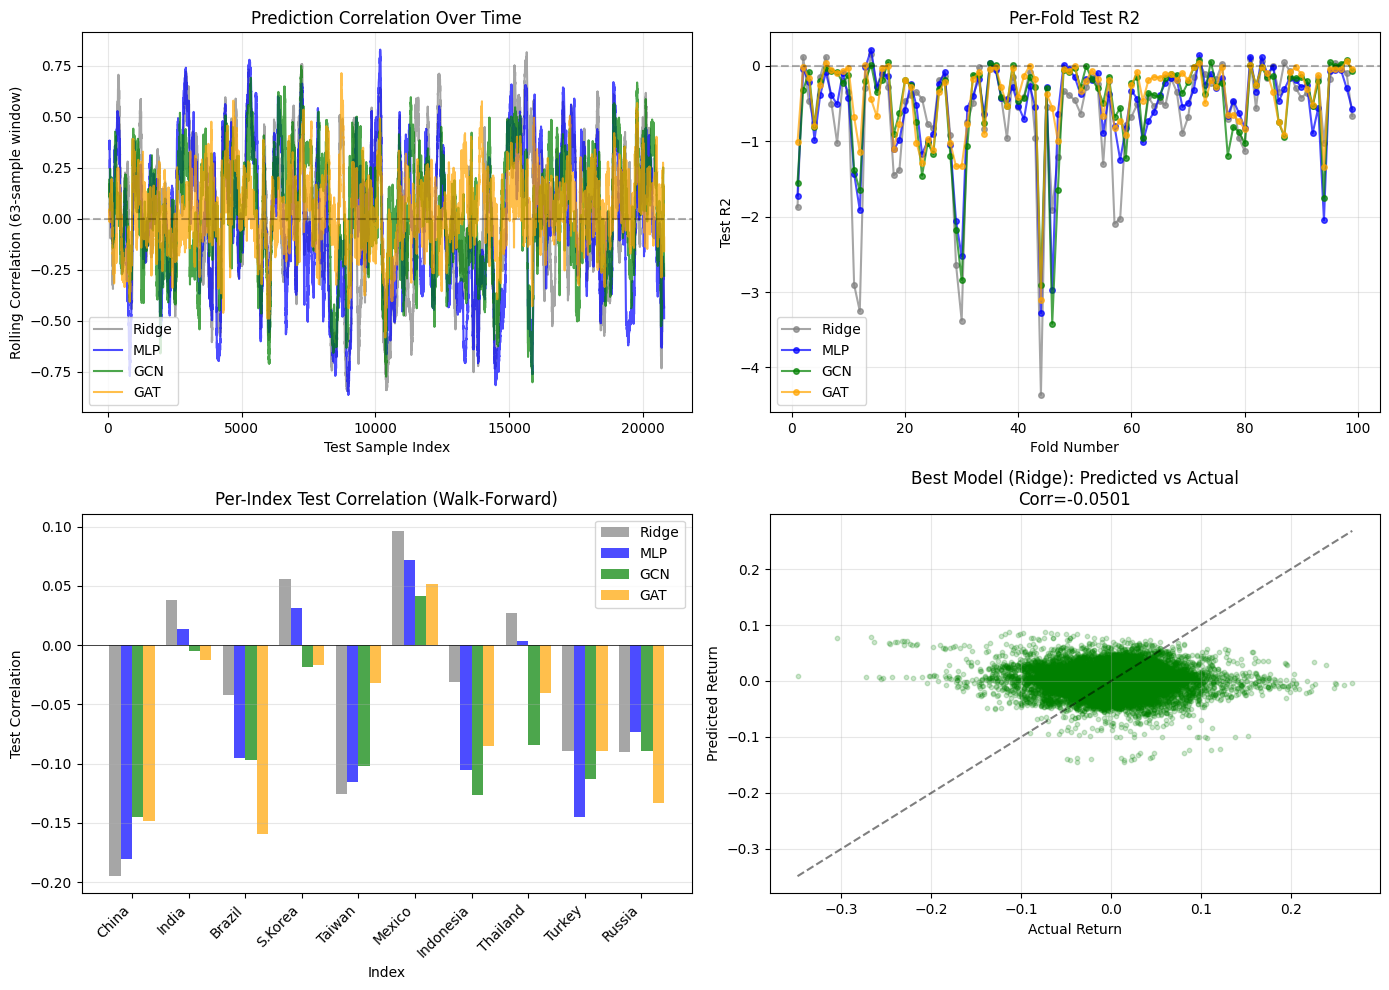

In [18]:
# Plot cumulative prediction accuracy over time
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Rolling correlation over time
ax = axes[0, 0]
window = 63  # Rolling window for correlation

for name, color in zip(model_names, ['gray', 'blue', 'green', 'orange']):
    y_true = wf_results[name]['y_true'].flatten()
    y_pred = wf_results[name]['y_pred'].flatten()
    
    # Compute rolling correlation
    n = len(y_true)
    rolling_corr = []
    for i in range(window, n):
        corr = np.corrcoef(y_true[i-window:i], y_pred[i-window:i])[0, 1]
        rolling_corr.append(corr)
    
    ax.plot(range(window, n), rolling_corr, label=name, alpha=0.7, color=color)

ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('Test Sample Index')
ax.set_ylabel('Rolling Correlation (63-sample window)')
ax.set_title('Prediction Correlation Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Per-fold R2
ax = axes[0, 1]
fold_r2 = {name: [] for name in model_names}

# Compute per-fold R2
start_idx = 0
for fold in folds:
    n_test = fold['test_end_idx'] - fold['test_start_idx']
    end_idx = start_idx + n_test
    
    for name in model_names:
        y_true = wf_results[name]['y_true'][start_idx:end_idx].flatten()
        y_pred = wf_results[name]['y_pred'][start_idx:end_idx].flatten()
        r2 = r2_score(y_true, y_pred)
        fold_r2[name].append(r2)
    
    start_idx = end_idx

x = range(1, len(folds) + 1)
for name, color in zip(model_names, ['gray', 'blue', 'green', 'orange']):
    ax.plot(x, fold_r2[name], marker='o', label=name, alpha=0.7, color=color, markersize=4)

ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('Fold Number')
ax.set_ylabel('Test R2')
ax.set_title('Per-Fold Test R2')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Per-index correlation comparison
ax = axes[1, 0]
x = np.arange(len(EM_NAMES))
width = 0.2

for i, (name, color) in enumerate(zip(model_names, ['gray', 'blue', 'green', 'orange'])):
    ax.bar(x + (i - 1.5) * width, per_index_corr[name], width, label=name, color=color, alpha=0.7)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Index')
ax.set_ylabel('Test Correlation')
ax.set_title('Per-Index Test Correlation (Walk-Forward)')
ax.set_xticks(x)
ax.set_xticklabels(EM_NAMES, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 4. Predicted vs Actual (best model)
ax = axes[1, 1]
best_model = max(wf_metrics, key=lambda k: wf_metrics[k]['corr'])
y_true = wf_results[best_model]['y_true'].flatten()
y_pred = wf_results[best_model]['y_pred'].flatten()

ax.scatter(y_true, y_pred, alpha=0.2, s=10, c='green')
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
ax.plot(lims, lims, 'k--', alpha=0.5)
ax.set_xlabel('Actual Return')
ax.set_ylabel('Predicted Return')
ax.set_title(f'Best Model ({best_model}): Predicted vs Actual\nCorr={wf_metrics[best_model]["corr"]:.4f}')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

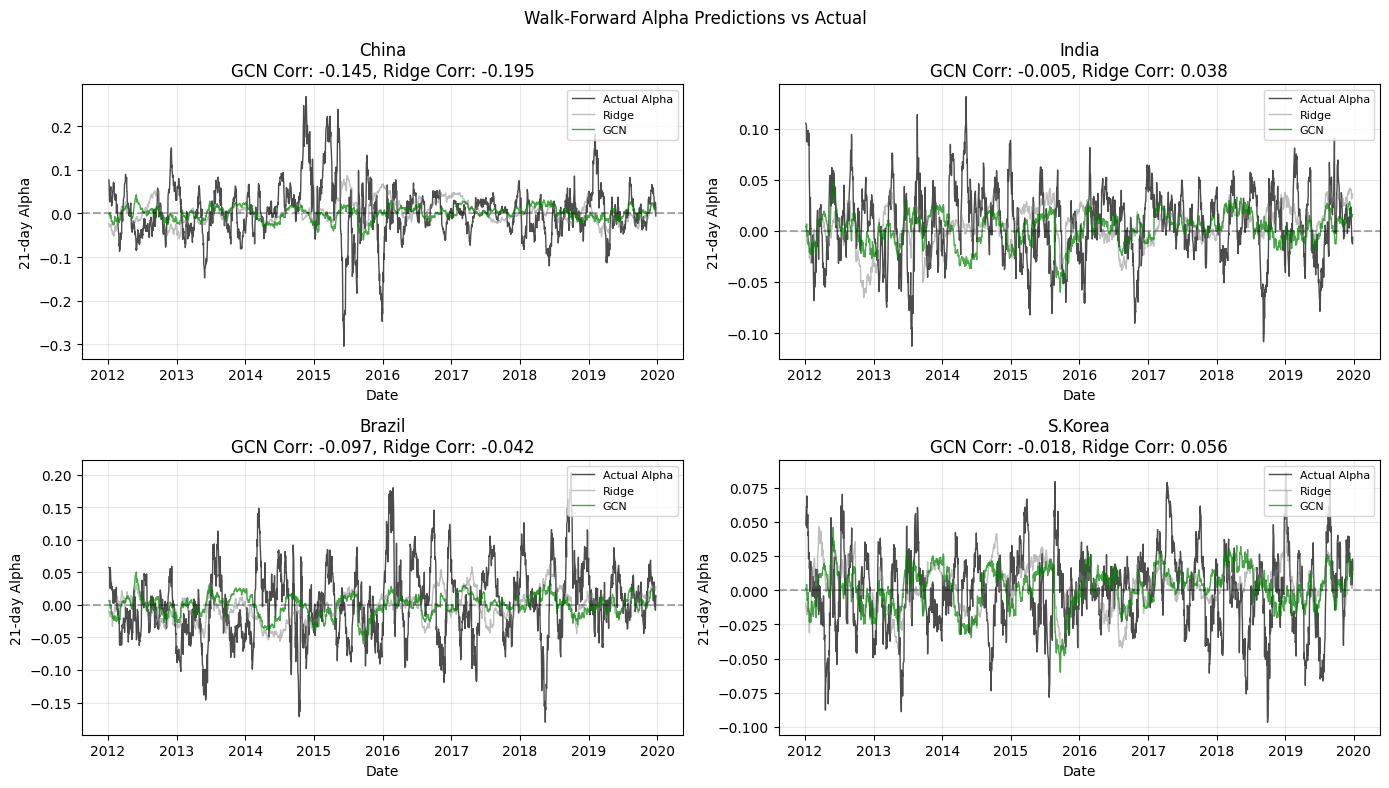

In [19]:
# Visualize alpha predictions over time for a sample index
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Pick 4 indices to visualize
sample_indices = [0, 1, 2, 3]  # China, India, Brazil, S.Korea

for ax, idx in zip(axes.flatten(), sample_indices):
    idx_name = EM_NAMES[idx]
    
    # Get dates and values
    dates = pd.to_datetime(wf_results['GCN']['dates'])
    y_true = wf_results['GCN']['y_true'][:, idx]
    y_pred_gcn = wf_results['GCN']['y_pred'][:, idx]
    y_pred_ridge = wf_results['Ridge']['y_pred'][:, idx]
    
    ax.plot(dates, y_true, label='Actual Alpha', alpha=0.7, color='black', linewidth=1)
    ax.plot(dates, y_pred_ridge, label='Ridge', alpha=0.5, color='gray', linewidth=1)
    ax.plot(dates, y_pred_gcn, label='GCN', alpha=0.7, color='green', linewidth=1)
    
    corr_gcn = np.corrcoef(y_true, y_pred_gcn)[0, 1]
    corr_ridge = np.corrcoef(y_true, y_pred_ridge)[0, 1]
    
    ax.set_title(f'{idx_name}\nGCN Corr: {corr_gcn:.3f}, Ridge Corr: {corr_ridge:.3f}')
    ax.set_xlabel('Date')
    ax.set_ylabel('21-day Alpha')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.suptitle('Walk-Forward Alpha Predictions vs Actual', fontsize=12)
plt.tight_layout()
plt.show()

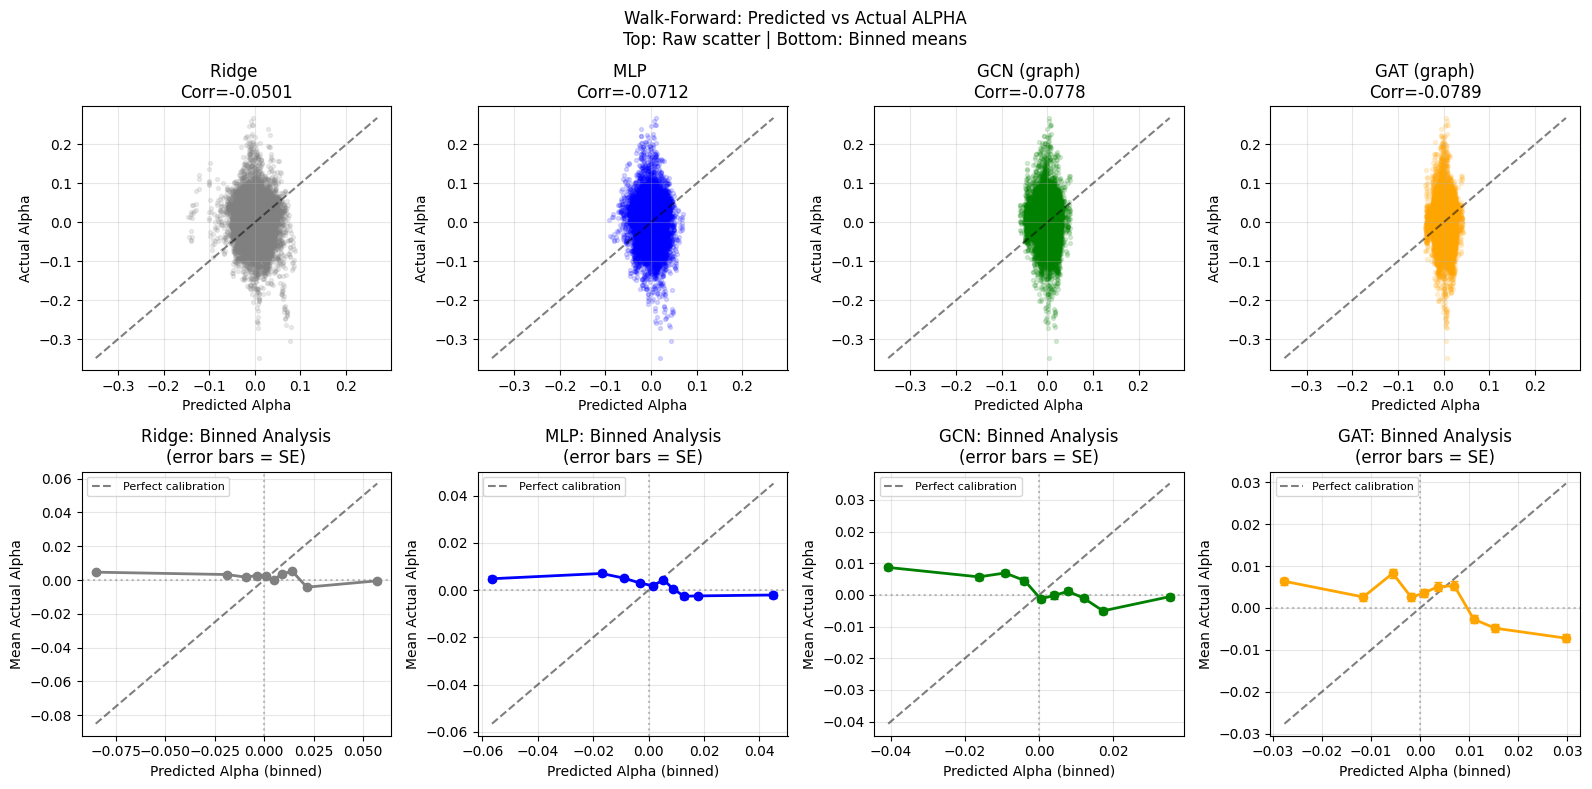


Calibration Summary (slope of binned means vs predicted alpha):
  Ridge: slope = -0.040 (1.0 = perfect calibration)
  MLP: slope = -0.097 (1.0 = perfect calibration)
  GCN: slope = -0.173 (1.0 = perfect calibration)
  GAT: slope = -0.254 (1.0 = perfect calibration)


In [20]:
# Predicted vs Actual scatter plots with binned analysis for ALPHA
# X-axis: Predicted alpha, Y-axis: Actual alpha

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

colors = {'Ridge': 'gray', 'MLP': 'blue', 'GCN': 'green', 'GAT': 'orange'}
n_bins = 10

for idx, name in enumerate(model_names):
    # Raw scatter plot (top row)
    ax = axes[0, idx]
    
    y_true = wf_results[name]['y_true'].flatten()
    y_pred = wf_results[name]['y_pred'].flatten()
    
    # Scatter: x=predicted, y=actual
    ax.scatter(y_pred, y_true, alpha=0.15, c=colors[name], s=8)
    
    # Add diagonal line
    lims = [min(y_pred.min(), y_true.min()), max(y_pred.max(), y_true.max())]
    ax.plot(lims, lims, 'k--', alpha=0.5, label='Perfect prediction')
    
    corr = wf_metrics[name]['corr']
    uses_graph = '(graph)' if name in ['GCN', 'GAT'] else ''
    
    ax.set_xlabel('Predicted Alpha')
    ax.set_ylabel('Actual Alpha')
    ax.set_title(f'{name} {uses_graph}\nCorr={corr:.4f}')
    ax.grid(True, alpha=0.3)
    
    # Binned scatter plot (bottom row)
    ax = axes[1, idx]
    
    # Create bins based on predicted values
    bin_edges = np.percentile(y_pred, np.linspace(0, 100, n_bins + 1))
    bin_edges = np.unique(bin_edges)  # Remove duplicates
    bin_centers = []
    bin_means = []
    bin_stds = []
    bin_counts = []
    
    for i in range(len(bin_edges) - 1):
        mask = (y_pred >= bin_edges[i]) & (y_pred < bin_edges[i+1])
        if i == len(bin_edges) - 2:  # Include right edge for last bin
            mask = (y_pred >= bin_edges[i]) & (y_pred <= bin_edges[i+1])
        
        if mask.sum() > 0:
            bin_centers.append((bin_edges[i] + bin_edges[i+1]) / 2)
            bin_means.append(y_true[mask].mean())
            bin_stds.append(y_true[mask].std() / np.sqrt(mask.sum()))  # Standard error
            bin_counts.append(mask.sum())
    
    bin_centers = np.array(bin_centers)
    bin_means = np.array(bin_means)
    bin_stds = np.array(bin_stds)
    
    # Plot binned means with error bars
    ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o-', 
                color=colors[name], capsize=3, markersize=6, linewidth=2)
    
    # Add diagonal line
    ax.plot([bin_centers.min(), bin_centers.max()], 
            [bin_centers.min(), bin_centers.max()], 
            'k--', alpha=0.5, label='Perfect calibration')
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
    
    ax.set_xlabel('Predicted Alpha (binned)')
    ax.set_ylabel('Mean Actual Alpha')
    ax.set_title(f'{name}: Binned Analysis\n(error bars = SE)')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle('Walk-Forward: Predicted vs Actual ALPHA\nTop: Raw scatter | Bottom: Binned means', fontsize=12)
plt.tight_layout()
plt.show()

# Print calibration summary
print("\nCalibration Summary (slope of binned means vs predicted alpha):")
for name in model_names:
    y_true = wf_results[name]['y_true'].flatten()
    y_pred = wf_results[name]['y_pred'].flatten()
    
    # Simple linear regression of binned means
    bin_edges = np.percentile(y_pred, np.linspace(0, 100, n_bins + 1))
    bin_edges = np.unique(bin_edges)
    bin_centers = []
    bin_means = []
    
    for i in range(len(bin_edges) - 1):
        mask = (y_pred >= bin_edges[i]) & (y_pred < bin_edges[i+1])
        if i == len(bin_edges) - 2:
            mask = (y_pred >= bin_edges[i]) & (y_pred <= bin_edges[i+1])
        if mask.sum() > 0:
            bin_centers.append((bin_edges[i] + bin_edges[i+1]) / 2)
            bin_means.append(y_true[mask].mean())
    
    if len(bin_centers) > 1:
        slope = np.polyfit(bin_centers, bin_means, 1)[0]
        print(f"  {name}: slope = {slope:.3f} (1.0 = perfect calibration)")

## 6. Analysis: Graph Structure

Let's visualize how the covariance-based graph evolves over time and how GNN leverages it.

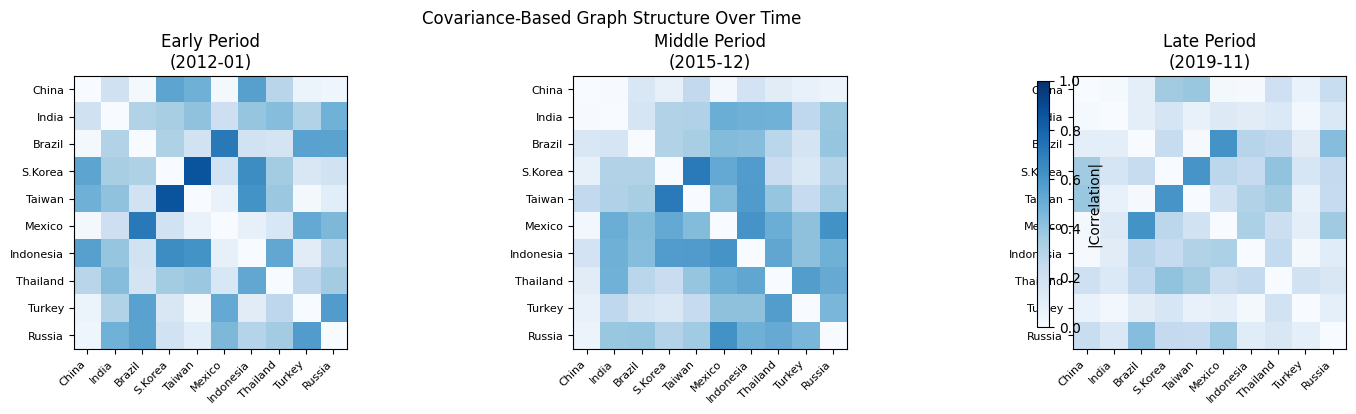

In [21]:
# Visualize graph structure at different time periods using walk-forward data
# Get adjacency matrices from first, middle, and last folds

# Prepare data for visualization from select folds
fold_indices = [0, len(folds)//2, len(folds)-1]
fold_labels = ['Early Period', 'Middle Period', 'Late Period']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, fold_idx, label in zip(axes, fold_indices, fold_labels):
    fold = folds[fold_idx]
    train_data, test_data = prepare_fold_data(
        features_aligned, returns, target_returns,
        fold['train_start_idx'], fold['train_end_idx'], 
        fold['test_start_idx'], fold['test_end_idx'],
        cov_window=COV_WINDOW
    )
    
    # Use first adjacency matrix from this fold's test period
    adj = test_data['adj'][0]
    
    im = ax.imshow(adj, cmap='Blues', vmin=0, vmax=1)
    ax.set_xticks(range(len(EM_NAMES)))
    ax.set_yticks(range(len(EM_NAMES)))
    ax.set_xticklabels(EM_NAMES, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(EM_NAMES, fontsize=8)
    ax.set_title(f'{label}\n({fold["test_start_date"].strftime("%Y-%m")})')

plt.colorbar(im, ax=axes, label='|Correlation|', shrink=0.8)
plt.suptitle('Covariance-Based Graph Structure Over Time', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Summary

### What We Demonstrated

1. **Real financial data**: 10 emerging market indices with actual price history
2. **35 features**: Technical, mean-reversion, cross-asset, MSCI World, calendar, and country dummies
3. **Dynamic graph**: Covariance matrix updated from prior 63-day returns
4. **Alpha target**: 21-day forward **beta-adjusted returns** (country return - beta × world return)
5. **Walk-forward evaluation**: Monthly retraining with 1-month buffer to avoid target leakage

### Why Alpha (Beta-Adjusted Return)?

Using alpha instead of total returns:
- **Removes global market exposure**: Isolates country-specific performance
- **More relevant for long-short strategies**: Focuses on relative over/under-performance
- **Better for country allocation**: Identifies which countries add value vs. simply tracking the world
- **Reduces noise**: Global market moves affect all EM countries similarly

**Formula**: `alpha = r_country - β × r_world`

Where β is the rolling 63-day beta of the country to MSCI World.

### Walk-Forward Methodology

- **Fixed 2-year training window** (~504 trading days): Always use most recent 2 years
- **Retrain every month** (~21 trading days): Models adapt to changing market conditions
- **1-month buffer**: Ensures training targets don't overlap with test period

```
|-- Rolling 2-Year Training (504 days) --|-- Buffer (21 days) --|-- Test (21 days) --|
         (fixed size, slides forward)
```

### Key Findings

- Walk-forward provides more realistic out-of-sample evaluation
- GNN models can leverage cross-market correlations through covariance-based graph
- Performance varies across market regimes (visible in per-fold results)
- Predicting alpha may be more stable than predicting total returns

### Financial Interpretation

The GNN approach is particularly valuable when:
- Markets exhibit contagion effects
- Global factors drive correlated moves
- Technical signals in one market predict relative performance in correlated markets

### Features Used (35 total)

| Category | Count | Features |
|----------|-------|----------|
| Technical | 10 | mom_21, mom_63, vol_21, rsi_14, ma_ratio_50, macd, bollinger, atr_14, vol_ratio, drawdown_63 |
| Mean-Reversion | 3 | dist_from_high_252, dist_from_low_252, return_zscore |
| Cross-Asset | 3 | corr_with_em_avg, cross_dispersion, beta_to_em_avg |
| MSCI World | 5 | world_mom_21, world_mom_63, world_vol_21, beta_to_world, corr_with_world |
| Calendar | 4 | month_sin, month_cos, dow_sin, dow_cos |
| Country | 10 | One-hot encoding for each country |

### Limitations

- Alpha prediction remains challenging (low R2 is typical in finance)
- Correlation structure may not be stable across regimes
- Transaction costs not considered
- Beta estimation has look-ahead bias within the 63-day window (though not across train/test)